# <center> Recommendation Systems 3693 Final Project
### <center> Deep Neural Networks for YouTube Recommendations
<center> Fall 2023


In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
!pip install zipfile36 --quiet
!pip install uszipcode --quiet

In [26]:
from zipfile import ZipFile

with ZipFile("src.zip", 'r') as zObject:
	zObject.extractall()

In [27]:
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from src.data.feature_extractor import FeatureExtractor
from src.data.importer import DataImporter
from src.data.ratings_dataset import RatingsDataset
from src.model.candidate_generation import CandidateGeneration
from src.model.popularity import Popularity
from src.trainer import Trainer
from src.utils import get_device
from src.model.candidate_generation_from_transformer import CandidateGenerationT
from src.visualizations import Plotter

<br></br>
## EDA

### Fetch MovieLens100k data

In [28]:
data_importer = DataImporter('http://files.grouplens.org/datasets/movielens/ml-100k.zip')
users_df, movies_df, genres, ratings_df = data_importer.import_data()

Data already exists


### Data exploration

In [29]:
plotter = Plotter()

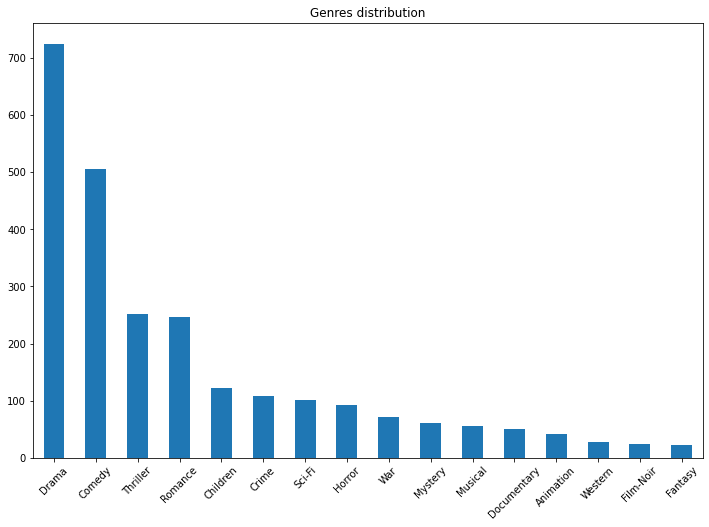

In [30]:
plotter.plot_genres_distribution(movies_df)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


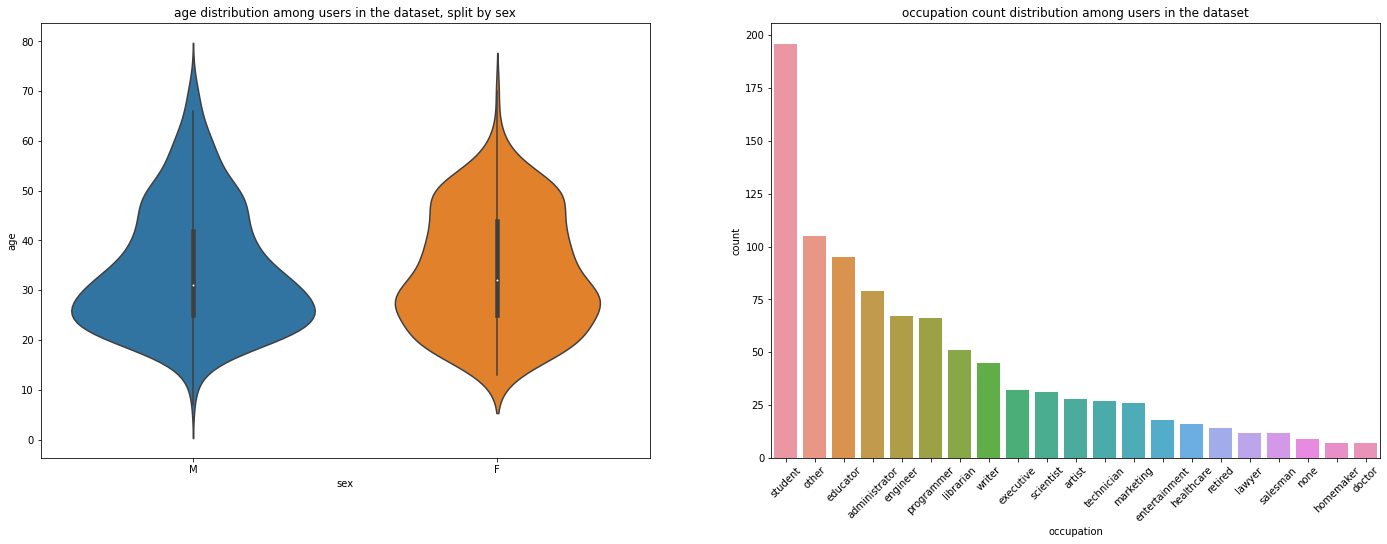

In [31]:
plotter.plot_user_distributions(users_df)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


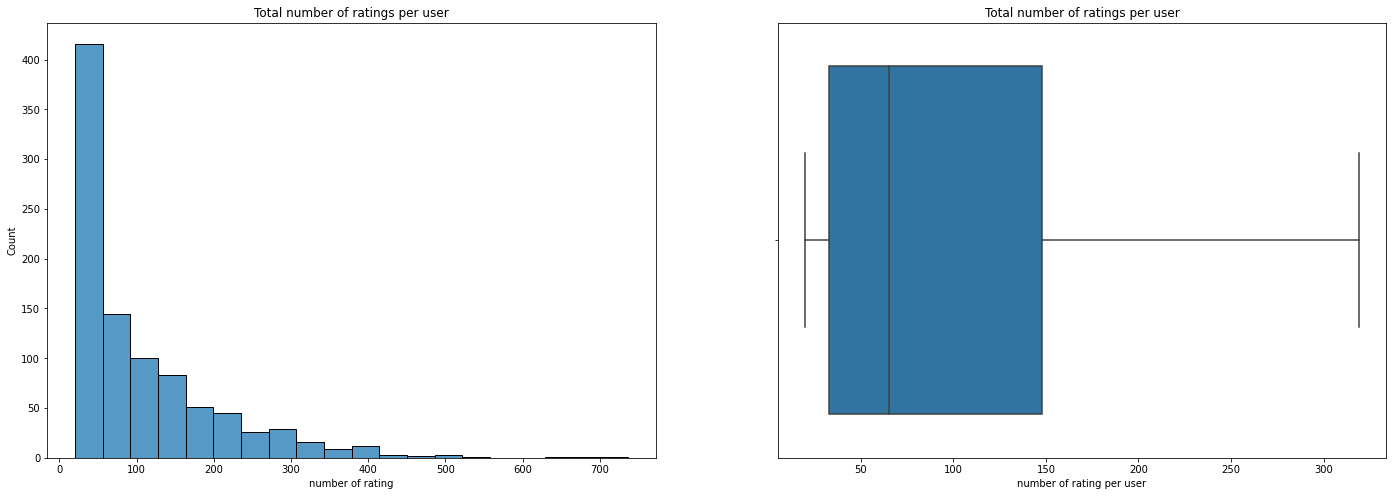

In [32]:
plotter.plot_ratings_distribution(ratings_df)

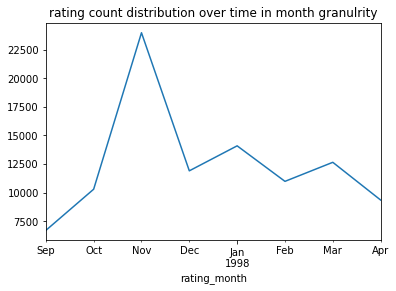

In [33]:
plotter.plot_rating_trends(ratings_df)

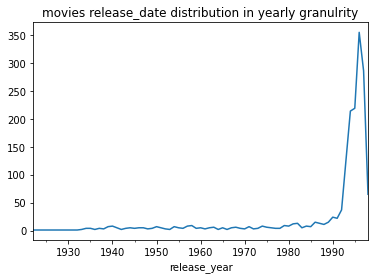

In [34]:
plotter.plot_movies_age_distribution(movies_df)

<br></br>
## Data Preprocessing

### Generate features and create examples df

In [35]:
f_extractor = FeatureExtractor(window_size=16)
examples_df = f_extractor.fit_transform(
    genres=genres,
    movies_df=movies_df,
    users_df=users_df,
    ratings_df=ratings_df
)

One-Hot user occupation matrix shape (943, 21)
One-Hot user gender matrix shape (943, 2)
One-Hot user geo area matrix shape (943, 4)
Using 90 examples per user_id
Using 32 examples per label
Examples shape  (49088, 7)


### Split train/validation examples

In [36]:
train_df, val_df = train_test_split(examples_df)

# Train Loader
train_dataset = RatingsDataset.from_df(train_df)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Validation Loader
val_dataset = RatingsDataset.from_df(val_df)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

<br></br>
## Model Training

Shared Hyperparams

In [37]:
EMBEDDING_DIMS = 256
DENSE_UNITS = 256
USER_DIM = 64
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 10

### Train Candidate generation model (original paper)

In [38]:
device = get_device()

cg_model = CandidateGeneration(
    n_items=movies_df.index.astype(int).max() + 2,
    n_search_items=len(genres) + 1,
    n_features=len(examples_df.iloc[0]['features']),
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=(2048, 1024, 512, 256),
    user_dim=USER_DIM
).to(device)

opt = Adam(cg_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is available!  Training on GPU ...


In [39]:
trainer = Trainer(cg_model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=EPOCHS)

Epoch 1/10, train loss: 7.3122, val loss: 7.2092, time: 1.46s
Epoch 2/10, train loss: 6.9114, val loss: 6.9112, time: 1.22s
Epoch 3/10, train loss: 6.4811, val loss: 6.5911, time: 1.38s
Epoch 4/10, train loss: 6.0061, val loss: 6.2911, time: 1.36s
Epoch 5/10, train loss: 5.5107, val loss: 6.0104, time: 1.40s
Epoch 6/10, train loss: 4.9964, val loss: 5.7614, time: 1.19s
Epoch 7/10, train loss: 4.4606, val loss: 5.5355, time: 1.65s
Epoch 8/10, train loss: 3.9083, val loss: 5.3343, time: 1.50s
Epoch 9/10, train loss: 3.3411, val loss: 5.1823, time: 1.35s
Epoch 10/10, train loss: 2.7635, val loss: 5.0494, time: 1.38s


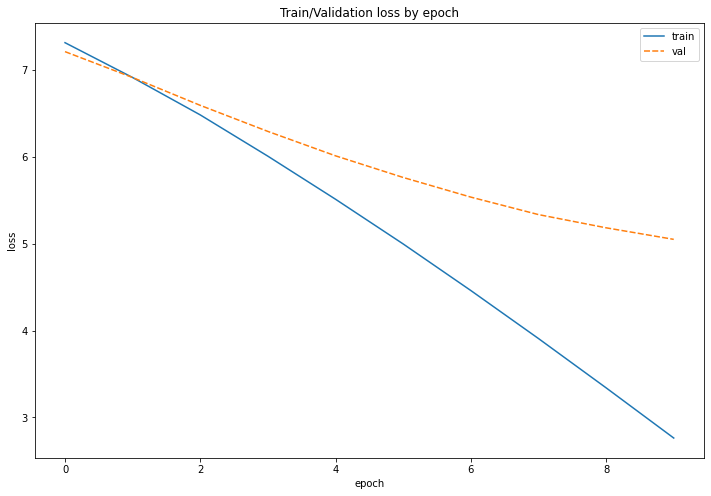

In [40]:
plotter.plot_loss_curves(train_losses, val_losses)

#### Evaluate Model


In [41]:
k = 10
print(f'candidate generation validation mrr @ {k}: ', cg_model.mrr(val_loader, k, device))
print(f'candidate generation validation hit rate @ {k}: ', cg_model.hit_rate(val_loader, k, device))

candidate generation validation mrr @ 10:  0.3906280721227328
candidate generation validation hit rate @ 10:  0.45678973454301075


<br></br>
### POP-based model (Baseline)

In [42]:
pop = Popularity()
pop.fit(ratings_df)

#### Evaluate Model

In [43]:
k = 10
print(f'popularity model validation mrr @ {k}: ', pop.mrr(val_loader, k))
print(f'popularity model validation hit rate @ {k}: ', pop.hit_rate(val_loader, k))

popularity model validation mrr @ 10:  0.0
popularity model validation hit rate @ 10:  0.0


<br></br>
### Transformer Based Recommendations

In [44]:
device = get_device()

cgt_model = CandidateGenerationT(
    n_items=movies_df.index.astype(int).max() + 2,
    n_search_items=len(genres) + 1,
    n_features=len(examples_df.iloc[0]['features']),
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=(2048, 1024, 512, 256),
    user_dim=USER_DIM
).to(device)

opt = Adam(cgt_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is available!  Training on GPU ...


In [45]:
trainer = Trainer(cgt_model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=EPOCHS)

Epoch 1/10, train loss: 7.1883, val loss: 7.0168, time: 17.90s
Epoch 2/10, train loss: 6.6031, val loss: 6.4688, time: 17.44s
Epoch 3/10, train loss: 6.0663, val loss: 6.0417, time: 17.53s
Epoch 4/10, train loss: 5.5428, val loss: 5.6536, time: 17.43s
Epoch 5/10, train loss: 5.0265, val loss: 5.2839, time: 17.76s
Epoch 6/10, train loss: 4.5267, val loss: 4.9310, time: 17.50s
Epoch 7/10, train loss: 4.0400, val loss: 4.6104, time: 17.78s
Epoch 8/10, train loss: 3.5668, val loss: 4.3247, time: 17.54s
Epoch 9/10, train loss: 3.1060, val loss: 4.0858, time: 17.58s
Epoch 10/10, train loss: 2.6625, val loss: 3.8840, time: 17.45s


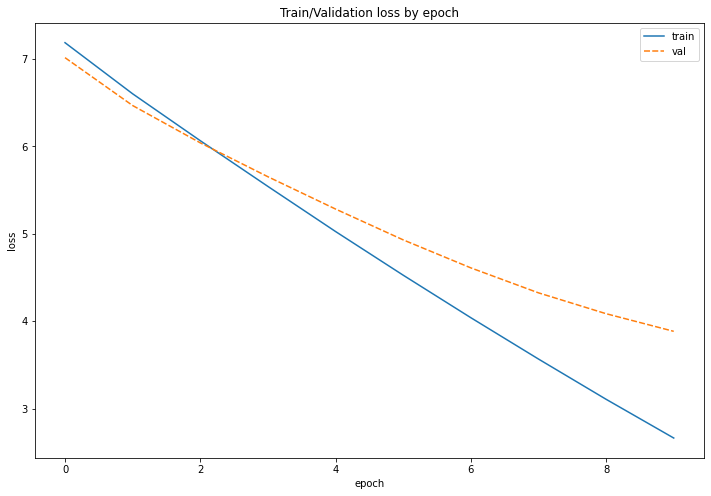

In [46]:
plotter.plot_loss_curves(train_losses, val_losses)

#### Evaluate Model

In [47]:
k = 10
print(f'candidate generation w transformer validation mrr @ {k}: ', cgt_model.mrr(val_loader, k, device))
print(f'candidate generation w transformer validation hit rate @ {k}: ', cgt_model.hit_rate(val_loader, k, device))

candidate generation w transformer validation mrr @ 10:  0.5651678716142973
candidate generation w transformer validation hit rate @ 10:  0.6243279569892474


<br></br>
## Compare models

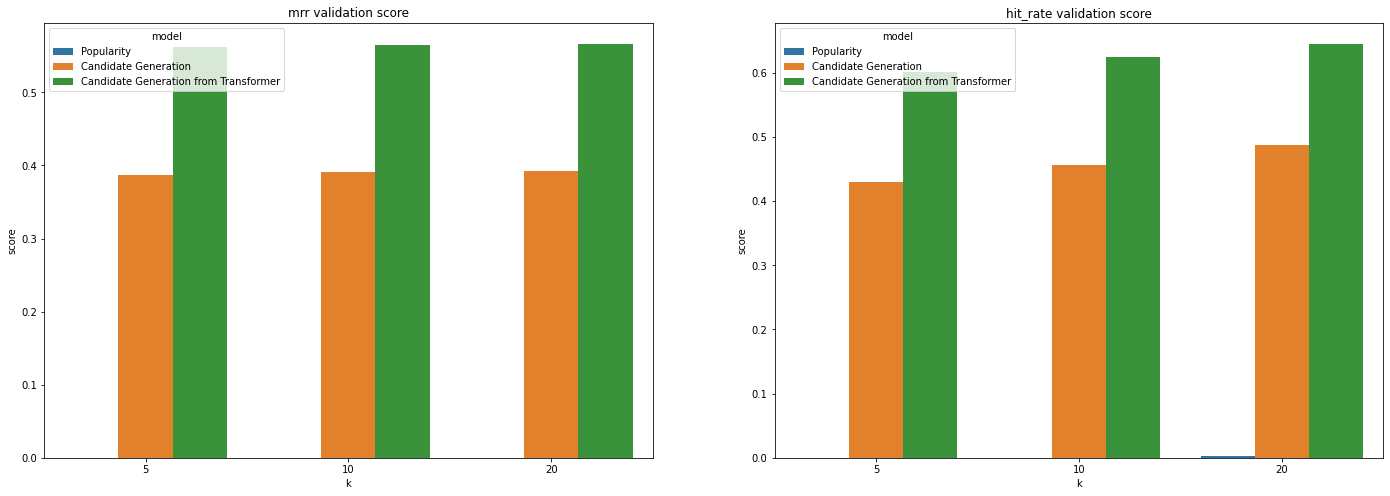

In [49]:
models = [
    (cg_model, 'Candidate Generation'),
    (pop, 'Popularity'),
    (cgt_model, 'Candidate Generation from Transformer')
]

plotter.plot_models_performance(
    models=models,
    val_loader=val_loader,
    device=device
)

